<div style="font-size:37px; font-weight:bold; line-height:1.1">
    Geostatistics: Direct Sampling
</div>

<p style="color:rgb(90,90,90);">
The MIT License (MIT)
<br>
Copyright (c) 2018 Massachusetts Institute of Technology
</p>
<p style="color:rgb(90,90,90);">
Author: Guillaume Rongier
<br>
We acknowledge support from NSF ACI1442997 (PI: V. Pankratius) and NASA AISTNNX15AG84G (PI: V. Pankratius).
</p>
<p style="color:rgb(90,90,90);">
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
</p>
<ul style="color:rgb(90,90,90);">
<li>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.</li>
<li>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</li>
</ul>

This notebook illustrates the use of the Direct Sampling, a Multiple-Point Simulation (MPS) method for stochastic simulation.

The most common geostatistical methods assume that a variable can be fully described by its first two moments, i.e., its distribution and a [variogram](http://petrowiki.org/Spatial_statistics#Semivariograms_and_covariance), which is called two-point statistics. But this is rarelly the case in real applications, where missing the higher-order statistics lead to a poor reproduction of the structures of interest. But infering those higher-order statistics from ponctual data, as done with the distribution and the variogram, is almost impossible.

MPS methods have been developed to circumvent such data partiality. Similarly to the [Sequential Gaussian Simulation](http://petrowiki.org/Geostatistical_conditional_simulation#Sequential_simulation) (SGS), they visit the nodes of a grid sequentially, and for each node to determine its value based on prior information. But instead of being a variogram, the prior information is a complete model of the variable to simulate, called training image (TI).

The [Direct Sampling](https:/doi.org/10.1029/2008WR007621) is a particular MPS method, which relies on a distance between the already-available values surrounding a node to simulate, and the same node configuration in the TI. When the distance is lower than a given threshold, the corresponding value in the TI becomes the value of the node. 

# Package imports

If you rely on Openblas to solve linear systems with NumPy, you should consider using the following set_env. Openblas has multithreading capabilities that dramaticaly slow down the SGS when the neighborhood (so the system to solve) is small

In [3]:
%set_env OPENBLAS_NUM_THREADS = 1

env: OPENBLAS_NUM_THREADS=1


In [4]:
%matplotlib notebook

import numpy as np

import matplotlib.pyplot as plt

from pyinsar.data_import.import_raster import open_sgems_file_from_url
from pyinsar.processing.machine_learning.geostatistics.direct_sampling import *
from pyinsar.processing.machine_learning.geostatistics.sequential_gaussian_simulation import *
from pyinsar.output.plot_raster import *

# Categorical simulation

## Unconditional simulation

In [5]:
file_url = 'http://www.trainingimages.org/uploads/3/4/7/0/34703305/ti_strebelle.sgems'
ti_array = open_sgems_file_from_url(file_url)[0]

<IPython.core.display.Javascript object>


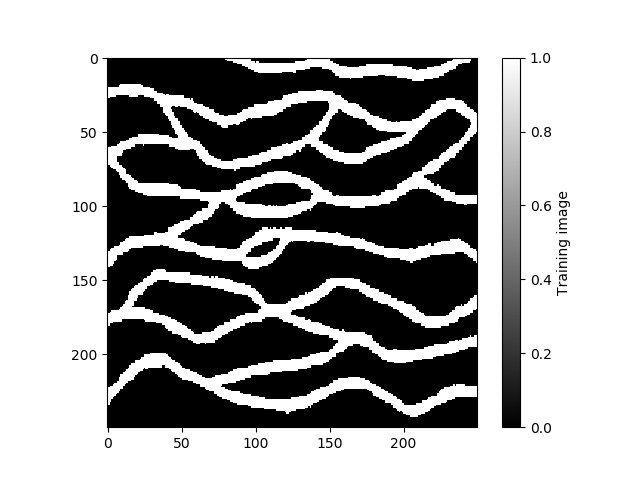

In [6]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(ti_array[0]),
                        cmap = 'gray', interpolation = 'None', rasterized = True,
                        zorder = 0)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Training image')
                
plt.show()

In [5]:
%%time

data_array = np.full(ti_array.shape, -99999.)

variable_types = [VariableType.DISCRETE]
distance_thresholds = [0.01]
ti_fraction = 0.5
max_number_data = [50]
max_density_data = [1.]
delta = 0.

max_non_matching_proportion = 1.
start_parameter_reduction = 0.75
reduction_factor = 3

number_postproc = 1
postproc_factor = 5

seed = 101

simulation_array = run_ds(data_array,
                          ti_array,
                          variable_types,
                          distance_thresholds,
                          ti_fraction,
                          max_number_data,
                          max_density_data,
                          delta = delta,
                          max_non_matching_proportion = max_non_matching_proportion,
                          start_parameter_reduction = start_parameter_reduction,
                          reduction_factor = reduction_factor,
                          number_postproc = number_postproc,
                          postproc_factor = postproc_factor,
                          seed = seed)

CPU times: user 3min 49s, sys: 3.07 s, total: 3min 52s
Wall time: 4min 22s


<IPython.core.display.Javascript object>


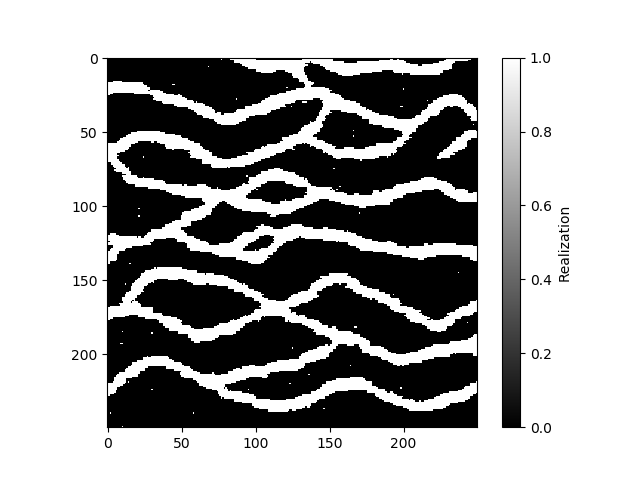

In [6]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(simulation_array[0, 0]),
                        cmap = 'gray', interpolation = 'None', rasterized = True,
                        zorder = 0)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Realization')
                
plt.show()

## Rotation and scaling

In [5]:
rotation_angle_array = np.full((sim_height, sim_width), 25.)
scaling_factor_array = np.array([[np.linspace(0.4, 1, sim_width),]*sim_height,]*2)

<IPython.core.display.Javascript object>


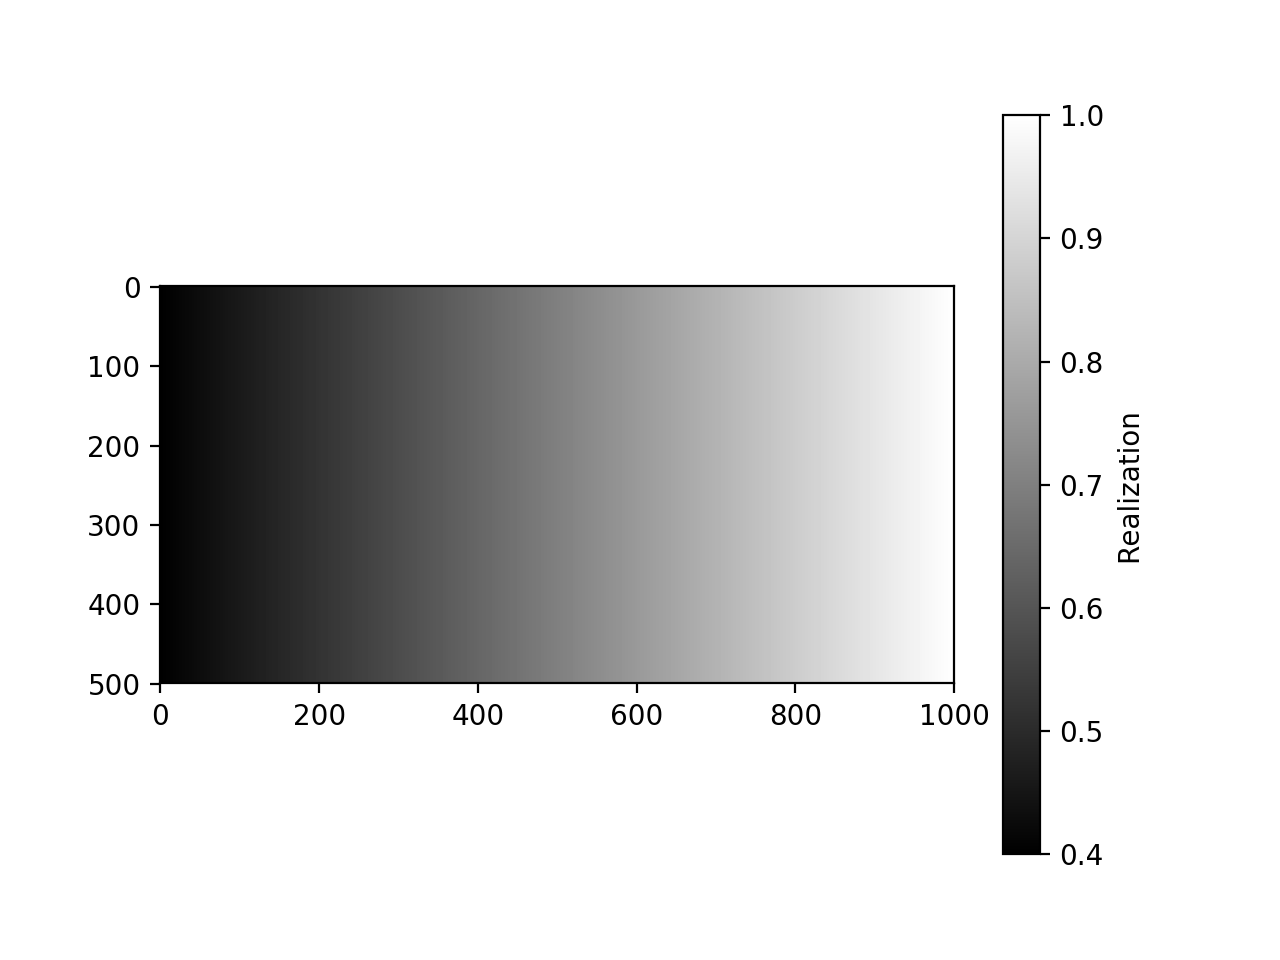

In [6]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(scaling_factor_array[0]),
                        cmap = 'gray', interpolation = 'None', rasterized = True,
                        zorder = 0)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Realization')
                
plt.show()

In [7]:
%%time

data_array = np.full((1, sim_height, sim_width), -99999.)

variable_types = [VariableType.DISCRETE]
distance_thresholds = [0.02]
ti_fraction = 0.5
max_number_data = [50]
max_density_data = [1.]

number_postproc = 1
postproc_factor = 5

seed = 101

simulation_array = run_ds(data_array,
                          ti_array,
                          variable_types,
                          distance_thresholds,
                          ti_fraction,
                          max_number_data,
                          max_density_data,
                          rotation_angle_array = rotation_angle_array,
                          scaling_factor_array = scaling_factor_array,
                          number_postproc = number_postproc,
                          postproc_factor = postproc_factor,
                          seed = seed)

CPU times: user 55min 52s, sys: 39.2 s, total: 56min 31s
Wall time: 1h 29s


<IPython.core.display.Javascript object>


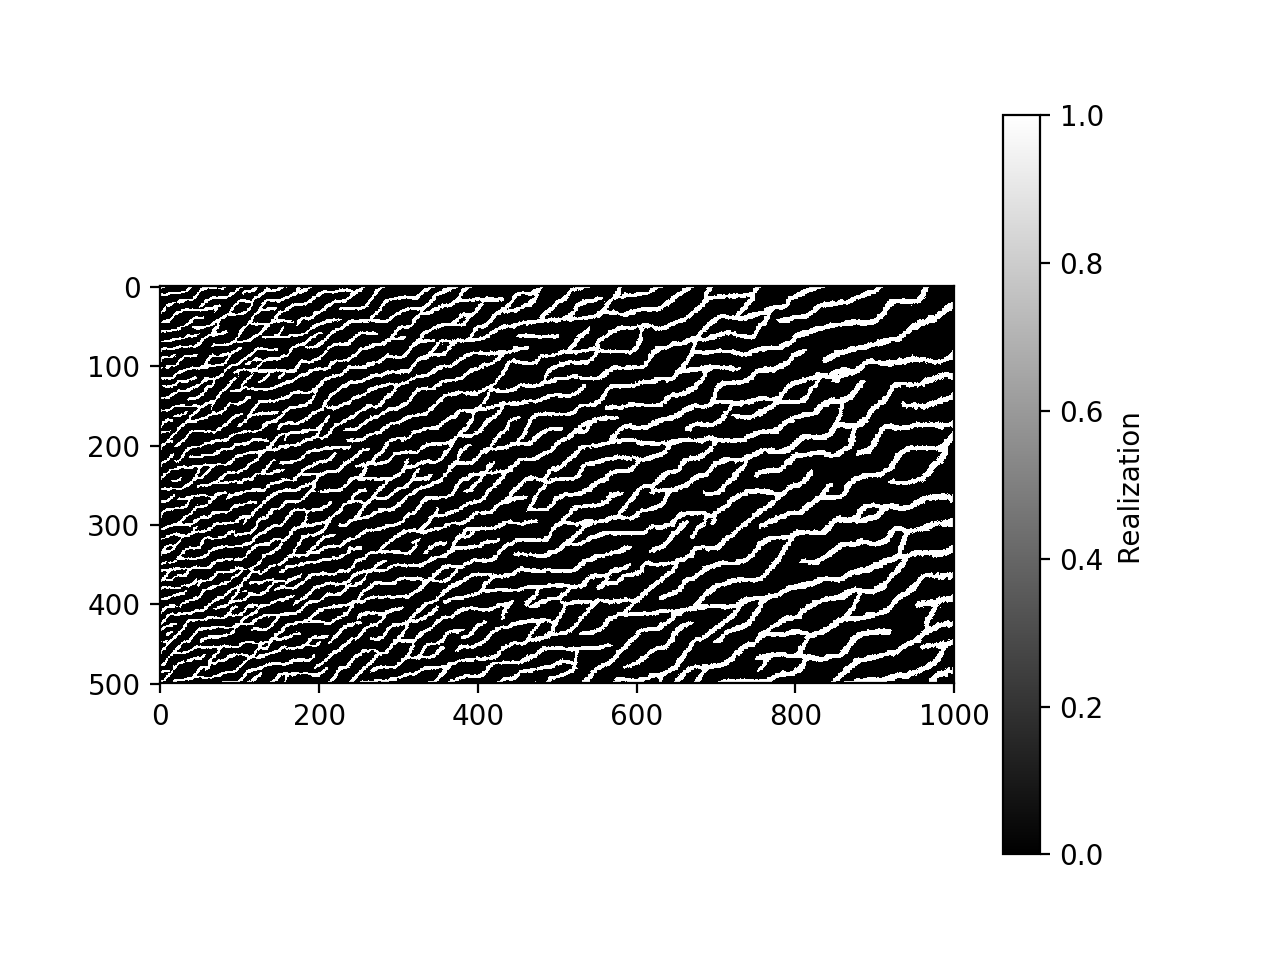

In [8]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(simulation_array[0, 0]),
                        cmap = 'gray', interpolation = 'None', rasterized = True,
                        zorder = 0)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Realization')
                
plt.show()

## Hard data conditioning

In [7]:
%%time

data_array = np.full(ti_array.shape, -99999.)

variable_types = [VariableType.DISCRETE]
distance_thresholds = [0.01]
ti_fraction = 0.35
max_number_data = [40]
max_density_data = [1.]
delta = 0.

max_non_matching_proportion = 1.
start_parameter_reduction = 1.
reduction_factor = 3

number_postproc = 1
postproc_factor = 5

seed = 101

simulation_array = run_ds(data_array,
                          ti_array,
                          variable_types,
                          distance_thresholds,
                          ti_fraction,
                          max_number_data,
                          max_density_data,
                          delta = delta,
                          max_non_matching_proportion = max_non_matching_proportion,
                          start_parameter_reduction = start_parameter_reduction,
                          reduction_factor = reduction_factor,
                          number_postproc = number_postproc,
                          postproc_factor = postproc_factor,
                          seed = seed)

CPU times: user 3min 25s, sys: 284 ms, total: 3min 25s
Wall time: 3min 25s


In [8]:
number_hard_data = 20

seed = 100

random.seed(seed)
count_hard_data = 0
hard_data_points = np.empty((number_hard_data, 2 + simulation_array.shape[1]))
hard_data = np.full(simulation_array.shape[1:], -99999.)
hard_data[np.isnan(simulation_array[0])] = np.nan
while count_hard_data < number_hard_data:
    j = random.randint(0, simulation_array.shape[2] - 1)
    i = random.randint(0, simulation_array.shape[3] - 1)
    if np.isnan(simulation_array[0, :, j, i]).all() == False:
        hard_data_points[count_hard_data, 0] = j
        hard_data_points[count_hard_data, 1] = i
        hard_data_points[count_hard_data, 2:] = simulation_array[0, :, j, i]
        hard_data[:, j, i] = simulation_array[0, :, j, i]
        count_hard_data += 1

<IPython.core.display.Javascript object>


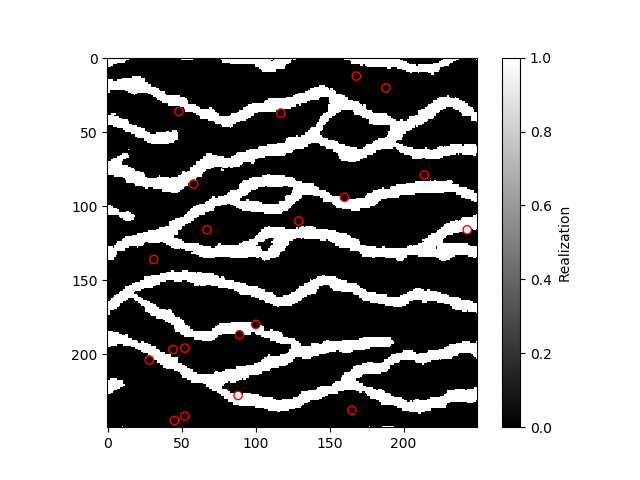

In [9]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(simulation_array[0, 0]),
                        cmap = 'gray', interpolation = 'None', rasterized = True,
                        zorder = 0)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Realization')

subfigure.scatter(hard_data_points[:, 1],
                  hard_data_points[:, 0],
                  c = hard_data_points[:, 2],
                  cmap = 'gray',
                  edgecolors = 'red')
                
plt.show()

In [11]:
%%time

variable_types = [VariableType.DISCRETE]
distance_thresholds = [0.1]
ti_fraction = 0.75
max_number_data = [40]
max_density_data = [1.]
delta = 0.
conditioning_data_weight = 5.

max_non_matching_proportion = 1.
# start_parameter_reduction = 1.
# reduction_factor = 3

number_postproc = 1
postproc_factor = 5

number_realizations = 4

seed = 101

simulation_array = run_parallel_ds(hard_data,
                                   ti_array,
                                   variable_types,
                                   distance_thresholds,
                                   ti_fraction,
                                   max_number_data,
                                   max_density_data,
                                   delta = delta,
                                   conditioning_data_weight = conditioning_data_weight,
                                   max_non_matching_proportion = max_non_matching_proportion,
                                   number_postproc = number_postproc,
                                   postproc_factor = postproc_factor,
                                   number_realizations = number_realizations,
                                   seed = seed)

CPU times: user 3min 36s, sys: 79.5 ms, total: 3min 36s
Wall time: 1min 2s


<IPython.core.display.Javascript object>


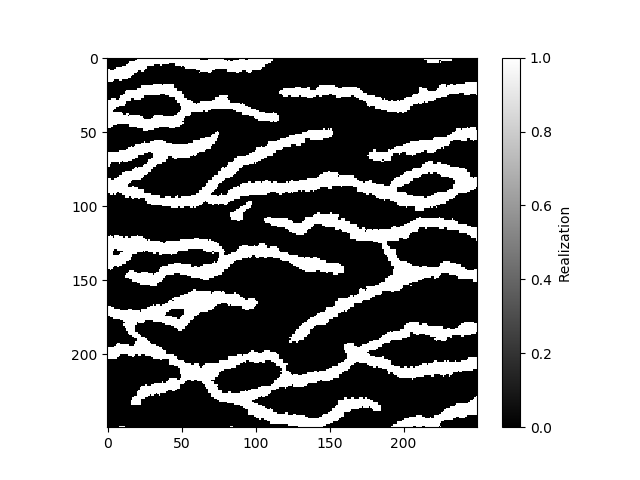

In [12]:
plot_interactive_slicing(simulation_array,
                         0,
                         cmap = 'gray',
                         clabel = 'Realization')

In [13]:
mean_simulation_array = np.nanmean(simulation_array[:,0,:,:], axis = 0)

<IPython.core.display.Javascript object>


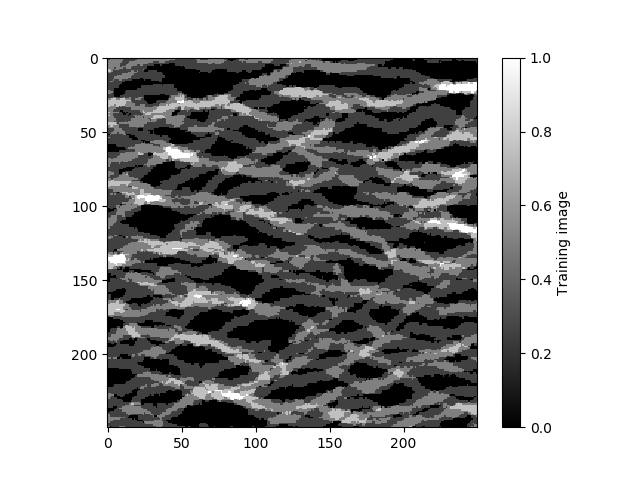

In [14]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(mean_simulation_array),
                        cmap = 'gray', interpolation = 'None', rasterized = True,
                        zorder = 0)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Training image')
                
plt.show()

# Continuous simulation

In [7]:
file_url = 'http://www.trainingimages.org/uploads/3/4/7/0/34703305/ti_stonewall.sgems'
ti_array = open_sgems_file_from_url(file_url)[0]

<IPython.core.display.Javascript object>


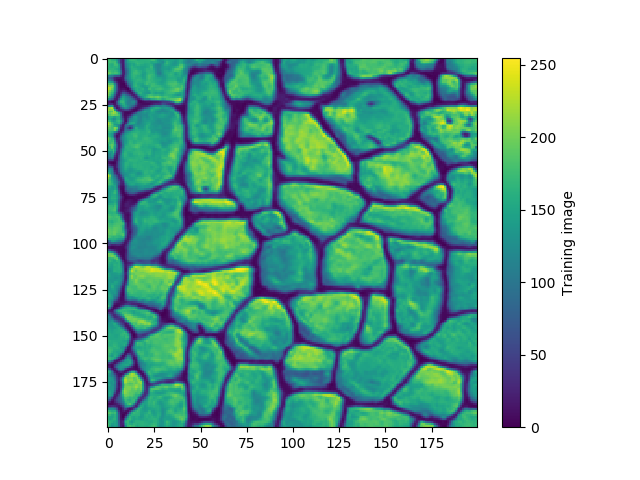

In [8]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(ti_array[0]),
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Training image')
                
plt.show()

In [9]:
%%time

data_array = np.full(ti_array.shape, -99999.)

variable_types = [VariableType.CONTINUOUS]
distance_thresholds = [0.02]
ti_fraction = 0.75
max_number_data = [50]
max_density_data = [1.]

number_postproc = 1
postproc_factor = 5

seed = 101

simulation_array = run_ds(data_array,
                          ti_array,
                          variable_types,
                          distance_thresholds,
                          ti_fraction,
                          max_number_data,
                          max_density_data,
                          number_postproc = number_postproc,
                          postproc_factor = postproc_factor,
                          seed = seed)

CPU times: user 7min 23s, sys: 6.15 s, total: 7min 29s
Wall time: 8min 23s


<IPython.core.display.Javascript object>


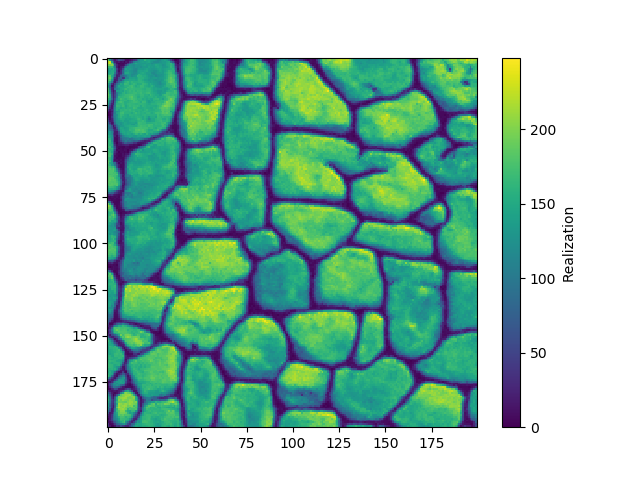

In [10]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(simulation_array[0, 0]),
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Realization')
                
plt.show()

# Multivariate simulation

## Setting

In [3]:
master_width = 250
master_height = 250

master_x_min = -20. # km
master_x_max = 20. # km
master_y_min = -20. # km
master_y_max = 20. # km

master_extent = (master_x_min, master_x_max, master_y_min, master_y_max) # km

grid_yx_spacing = ((master_y_max - master_y_min)/master_height,
                   (master_x_max - master_x_min)/master_width)

ti_width = 500
ti_height = 500

## Training image

In [4]:
%%time

data_array = np.full((ti_height, ti_width), -99999.)

vario_models = (VariogramModel.NUGGET, VariogramModel.GAUSSIAN)
vario_sills = (0.0001, 1.)
vario_azimuth = 145
vario_ranges = ((0., 0.), (12., 7.))

number_realizations = 2
seed = 105

raw_training_image_array = run_sgs(data_array,
                                   grid_yx_spacing,
                                   vario_models,
                                   vario_sills,
                                   vario_azimuth,
                                   vario_ranges,
                                   number_realizations = number_realizations,
                                   seed = seed)

CPU times: user 10.7 s, sys: 168 ms, total: 10.9 s
Wall time: 11.7 s


In [5]:
training_image_mean = 0. # meter
training_image_std = 2. # meter
training_image_skew = 0.5
cumulative_frequency = compute_averaged_cumulative_distribution_from_array(raw_training_image_array[0])
training_image_array = stats.lognorm.ppf(cumulative_frequency,
                                         s = training_image_skew,
                                         loc = training_image_mean,
                                         scale = training_image_std)

In [6]:
threshold_high = 2.
threshold_low = 0.
training_image_classif_array = np.full(training_image_array.shape, np.nan)
training_image_classif_array[(threshold_low < training_image_array) & (training_image_array < threshold_high)] = 0
training_image_classif_array[(threshold_low >= training_image_array)] = 1
training_image_classif_array[(training_image_array >= threshold_high)] = 1

In [7]:
training_image_array = np.array([training_image_array, training_image_classif_array])

<IPython.core.display.Javascript object>


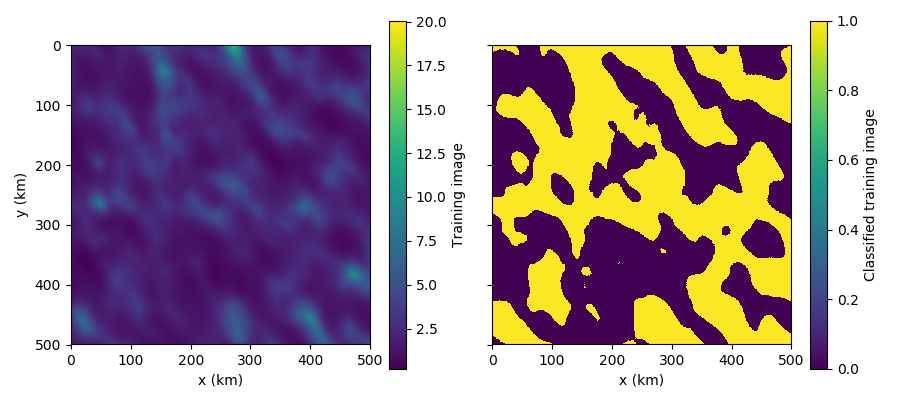

In [8]:
figure, subplots = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (9, 4))

raster_map = subplots[0].imshow(np.ma.masked_invalid(training_image_array[0]), #extent = master_extent,
                                cmap='viridis', interpolation = 'None', rasterized = True,
                                zorder = 0)
raster_map_colorbar = plt.colorbar(raster_map, ax = subplots[0])
raster_map_colorbar.set_label('Training image')
subplots[0].set_xlabel('x (km)')
subplots[0].set_ylabel('y (km)')

raster_map = subplots[1].imshow(np.ma.masked_invalid(training_image_array[1]), #extent = master_extent,
                                cmap='viridis', interpolation = 'None', rasterized = True,
                                zorder = 0)
raster_map_colorbar = plt.colorbar(raster_map, ax = subplots[1])
raster_map_colorbar.set_label('Classified training image')
subplots[1].set_xlabel('x (km)')

plt.tight_layout()
                
plt.show()

## Simulations

In [21]:
%%time

data_array = np.full((2, master_height, master_width), -99999.)

variable_types = (VariableType.CONTINUOUS, VariableType.DISCRETE)
distance_thresholds = (0.01, 0.05)
ti_fraction = 0.5
max_number_data = (30, 30)
max_density_data = (1. , 1.)

number_postproc = 1
postproc_factor = 1

seed = 100

simulation_array = run_ds(data_array,
                          training_image_array,
                          variable_types,
                          distance_thresholds,
                          ti_fraction,
                          max_number_data,
                          max_density_data,
                          number_postproc = number_postproc,
                          postproc_factor = postproc_factor,
                          seed = seed)

CPU times: user 11min, sys: 5.85 s, total: 11min 6s
Wall time: 11min 29s


<IPython.core.display.Javascript object>


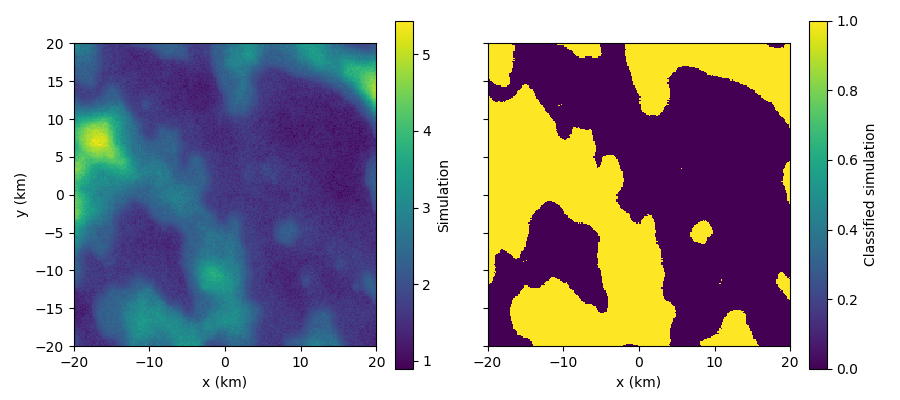

In [22]:
figure, subplots = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (9, 4))

raster_map = subplots[0].imshow(np.ma.masked_invalid(simulation_array[0, 0]), extent = master_extent,
                                cmap='viridis', interpolation = 'None', rasterized = True,
                                zorder = 0)
raster_map_colorbar = plt.colorbar(raster_map, ax = subplots[0])
raster_map_colorbar.set_label('Simulation')
subplots[0].set_xlabel('x (km)')
subplots[0].set_ylabel('y (km)')

raster_map = subplots[1].imshow(np.ma.masked_invalid(simulation_array[0, 1]), extent = master_extent,
                                cmap='viridis', interpolation = 'None', rasterized = True,
                                zorder = 0)
raster_map_colorbar = plt.colorbar(raster_map, ax = subplots[1])
raster_map_colorbar.set_label('Classified simulation')
subplots[1].set_xlabel('x (km)')

plt.tight_layout()
                
plt.show()

In [23]:
%%time

data_array = np.full((2, master_height, master_width), -99999.)

rotation_angle_array = np.full((master_height, master_width), -90.)
scaling_factor_array = np.full((2, master_height, master_width), 2.)

variable_types = (VariableType.CONTINUOUS, VariableType.DISCRETE)
distance_thresholds = (0.01, 0.05)
ti_fraction = 0.5
max_number_data = (30, 30)
max_density_data = (1., 1.)

number_postproc = 0
postproc_factor = 1

seed = 100

simulation_array = run_ds(data_array,
                          training_image_array,
                          variable_types,
                          distance_thresholds,
                          ti_fraction,
                          max_number_data,
                          max_density_data,
                          rotation_angle_array = rotation_angle_array,
                          scaling_factor_array = scaling_factor_array,
                          number_postproc = number_postproc,
                          postproc_factor = postproc_factor,
                          seed = seed)

CPU times: user 4min 40s, sys: 1.28 s, total: 4min 41s
Wall time: 4min 46s


<IPython.core.display.Javascript object>


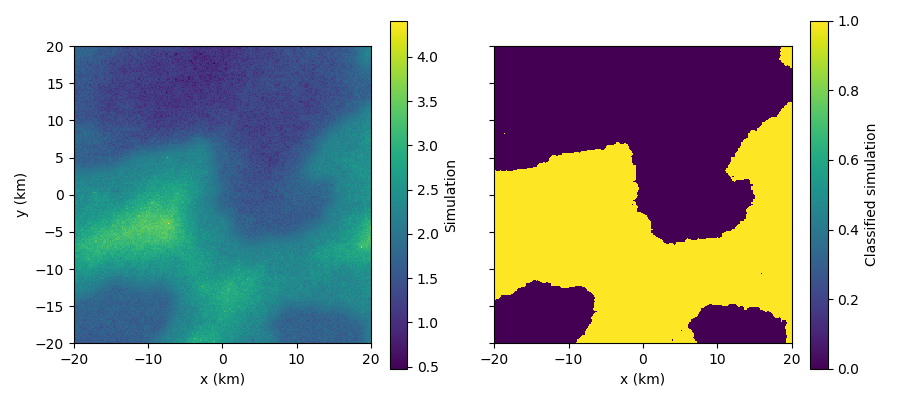

In [24]:
figure, subplots = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (9, 4))

raster_map = subplots[0].imshow(np.ma.masked_invalid(simulation_array[0, 0]), extent = master_extent,
                                cmap='viridis', interpolation = 'None', rasterized = True,
                                zorder = 0)
raster_map_colorbar = plt.colorbar(raster_map, ax = subplots[0])
raster_map_colorbar.set_label('Simulation')
subplots[0].set_xlabel('x (km)')
subplots[0].set_ylabel('y (km)')

raster_map = subplots[1].imshow(np.ma.masked_invalid(simulation_array[0, 1]), extent = master_extent,
                                cmap='viridis', interpolation = 'None', rasterized = True,
                                zorder = 0)
raster_map_colorbar = plt.colorbar(raster_map, ax = subplots[1])
raster_map_colorbar.set_label('Classified simulation')
subplots[1].set_xlabel('x (km)')

plt.tight_layout()
                
plt.show()

# Parallel Direct Sampling

Due to the sequential nature of the DS, paralleizing the algorithm is difficult. But Simulating several realizations is an embarrassingly parallel problem, because each realizations is independant from the others.

In [11]:
file_url = 'http://www.trainingimages.org/uploads/3/4/7/0/34703305/ti_strebelle.sgems'
ti_array = open_sgems_file_from_url(file_url)[0]

<IPython.core.display.Javascript object>


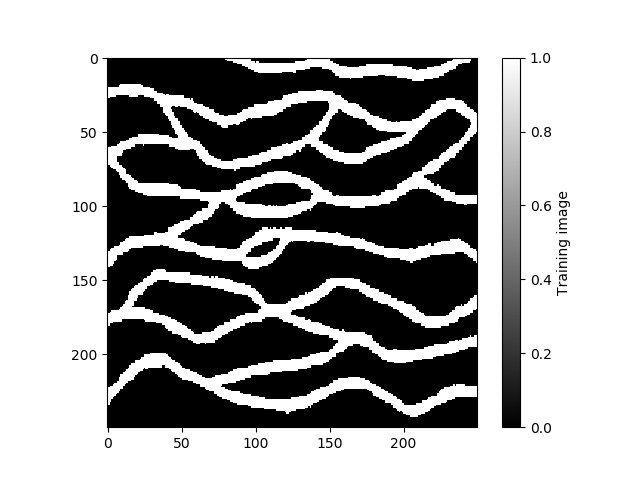

In [12]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(ti_array[0]),
                        cmap = 'gray', interpolation = 'None', rasterized = True,
                        zorder = 0)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Training image')
                
plt.show()

In [13]:
%%time

data_array = np.full(ti_array.shape, -99999.)

variable_types = [VariableType.DISCRETE]
distance_thresholds = [0.02]
ti_fraction = 0.5
max_number_data = [50]
max_density_data = [1.]

number_postproc = 1
postproc_factor = 5

number_realizations = 4

seed = 101

simulation_array = run_parallel_ds(data_array,
                                   ti_array,
                                   variable_types,
                                   distance_thresholds,
                                   ti_fraction,
                                   max_number_data,
                                   max_density_data,
                                   number_postproc = number_postproc,
                                   postproc_factor = postproc_factor,
                                   number_realizations = number_realizations,
                                   seed = seed)

CPU times: user 14min 43s, sys: 5.43 s, total: 14min 48s
Wall time: 5min 19s


<IPython.core.display.Javascript object>


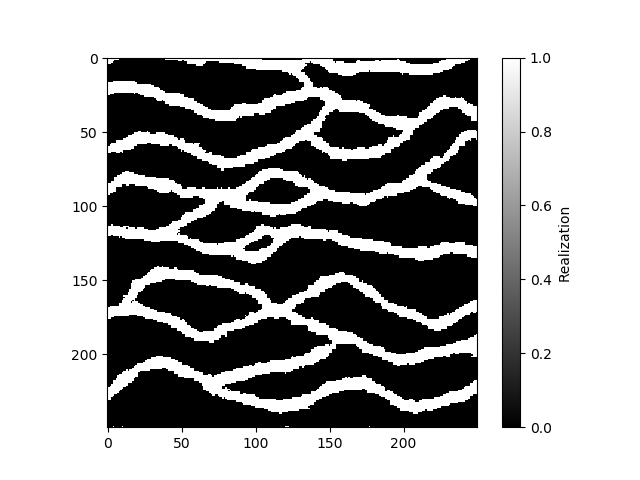

interactive(children=(BoundedIntText(value=0, description='Slice', max=3), Output()), _dom_classes=('widget-interact',))

In [14]:
plot_interactive_slicing(simulation_array,
                         0,
                         cmap = 'gray',
                         clabel = 'Realization')